### 1. These cells will run in the cluster..

In [8]:
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
import os
from tqdm import tqdm
import numpy as np
from torch.nn import CrossEntropyLoss
from evaluate import logging
import pickle
import collections
import glob
import math
import time


In [2]:
def remove_characters(sequence, char_list):
    columns = sequence.split('<sep>')
    seq = columns[1]
    for char in char_list:
        seq = seq.replace(char, '')
    return seq

In [3]:
def calculatePerplexity(input_ids,model,tokenizer):
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    return math.exp(loss)

In [ ]:
def main(label, model,special_tokens,device,tokenizer):
    input_ids = tokenizer.encode(label,return_tensors='pt').to(device)
    outputs = model.generate(
        input_ids, 
    	top_k=9, #tbd
        repetition_penalty=1.2,
        max_length=1024,
        eos_token_id=1,
        pad_token_id=0,
   	    do_sample=True,
   	    num_return_sequences=3000)
    
    # Check sequence sanity, sequences not-truncated
    new_outputs = [ output for output in outputs if output[-1] == 0]
    if not new_outputs:
        print("not enough sequences with short lengths!!")
    
    ppls = [(tokenizer.decode(output), calculatePerplexity(output, model, tokenizer)) for output in new_outputs ]
    print(ppls)
    #ppl = list(zip(ppls, [tokenizer.decode(output) for output in new_outputs]))
    ppls.sort(key=lambda i:i[1])
    ppls = list(set(ppls))
    #first_seq,second_seq = ppl[:2]
    print(ppls)
    inf_res={}
    inf_res[label] = [(remove_characters(x[0], special_tokens), x[1]) for x in ppls]

    return inf_res


In [ ]:
if __name__=='__main__':
    device = torch.device("cuda")
    print('Reading pretrained model and tokenizer')
    tokenizer = AutoTokenizer.from_pretrained('/home/woody/b114cb/b114cb10/zymCTRL/tokenizer')
    model = GPT2LMHeadModel.from_pretrained('/home/woody/b114cb/b114cb10/zymCTRL/train/output').to(device) # change to new one
    special_tokens = ['<start>', '<end>', '<|endoftext|>','<pad>',' ', '<sep>']
    labels=['4.2.1.1']
    print(len(labels))

    for label in tqdm(labels):
        for i in range(10,100):
            inf_res = main(label,model,special_tokens,device,tokenizer)
            for key,value in inf_res.items():
                for index, val in enumerate(value):            
                    fn = open(f"/home/woody/b114cb/b114cb10/zymCTRL/selection-generation/4.2.1.1/{label}_{i}_{index}.fasta", "w")
                    fn.write(f'>{label}_{i}_{index}\t{val[1]}\n{val[0]}')
                    fn.close()


# 2. Filter out duplicates and sort by ppl

In [25]:
fasta_files = glob.glob('/agh/projects/noelia/NLP/zymCTRL/selection-generation/4.2.1.1/*.fasta')

In [26]:
sequences = []
for fasta in fasta_files:
    fasta_file = open(fasta)
    header = fasta_file.readline()
    nname, ppl = header.split()
    name = nname.split('>')[1]

    sequences.append([name, ppl,fasta_file.readline()])
    fasta_file.close()
                     

In [27]:
sequences

[['4.2.1.1_520_55',
  '1.1446619975597574',
  'MPNSNPVSAWKALRQGNERFISGEPSHPSQGIEDRSRLATGQKPTAVIFGCGDSRVAAELIFDQGLGDMFVVRTAGQAIDTAVLGSIEYAVANLDVKLVVVLGHDSCGAVQAAINSLDTGELPGGYVRDIVERVMPSILMGRREGLSRVDEFEVRHVVETNVQMMMQRSSAIADGIAAGTQAIVGATYHMADGRAELRDHMGDIGES'],
 ['4.2.1.1_620_33',
  '1.2396162955251957',
  'MAENDINRLFVQNRSWAESKAAGDPNFFERLAHQQAPKYLWIGCSDSRVPANQIVDLPPGEVFVHRNVANVVVHTDHNCLSVMQFAVDVLKVEHIMVVGHYGCGGVQAVLHDERYGFIDNWLRHVGDVRDQHADMMAQIERSHHREALCELNVIEQVRNVARTNVVQDAWERGQALSVHGWCYSLRNGHMSDLSLTVGSTADLERVYKKAIAAVAGGESS'],
 ['4.2.1.1_412_41',
  '1.1795117942702347',
  'MSEHDLPTPADVFEMLLRGNARFVSDTAIHPNQDAARRAETAPSQQPFAVLFGCSDSRLAAEIIFDRGLGDLFVVRTAGHVMGPEVLGSVEYGVSVLGCPLVVVLGHDSCGAVGAACAALEGGVPPAGYVRDVVERVTPSVLAARASGRVDAETILEHVRHTVDLLLERSRVLASAIADGRTAVVGLRYRLTDGSADAVAAQGLTTRATGSGPAT'],
 ['4.2.1.1_609_53',
  '1.143705903299917',
  'MPNSNPVSAWKTLREGNERFVAGEPLHPSQGIEHRAALADSQHPTAVIFGCGDSRVAAELIFDQGLGDMFVVRTAGHVMDSAVLGSIEYSVAVLNVPLIVVLGHDSCGAIKATLDALDQGAVPGGFVRGVVDRVMPSILMGKREGLSRVDEFEARHVTE

## Sort them by the ppl value

In [28]:
sequences.sort(key=lambda x: x[1])

In [30]:
len(sequences)

63178

In [37]:
# I see many duplicates. Remove them!
sequences_after_filtering = []
a=[(x[0],x[1],x[2],sequences_after_filtering.append(x[2])) for x in sequences if x[2] not in sequences_after_filtering]
# i know this is very hacky but works fast which is what i need now!

In [38]:
len(sequences_after_filtering) # not that many filtered out 

62753

In [40]:
len(a)

62753

## Write out the first 3,000

In [41]:
a[0]

('4.2.1.1_77_47',
 '1.012109380556926',
 'MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHSGCGGIKAAVENPELGLINNWLLHIRDIWLKHSSLLGKMPEEQRLDALYELNVMEQVYNLGHSTIMQSAWKRGQNVTIHGWAYSINDGLLRDLDVTATNRETLENGYHKGISALSLKYIPHQ',
 None)

In [43]:
import shutil
for item in a[:3000]:
    shutil.copyfile(f'/agh/projects/noelia/NLP/zymCTRL/selection-generation/4.2.1.1/{item[0]}.fasta',
                    f'/agh/projects/noelia/NLP/zymCTRL/selection-generation/4.2.1.1/selection/{item[0]}.fasta')
    


In [48]:
np.mean([float(x[1]) for x in a[:3000]])

1.0282212210708528

In [49]:
np.std([float(x[1]) for x in a[:3000]])

0.0054012003836943915

In [50]:
ab = [[x[0],x[1],x[2]] for x in a]

In [51]:
ab

[['4.2.1.1_77_47',
  '1.012109380556926',
  'MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHSGCGGIKAAVENPELGLINNWLLHIRDIWLKHSSLLGKMPEEQRLDALYELNVMEQVYNLGHSTIMQSAWKRGQNVTIHGWAYSINDGLLRDLDVTATNRETLENGYHKGISALSLKYIPHQ'],
 ['4.2.1.1_42_59',
  '1.012813089583945',
  'MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHYGCGGVQAAVENPELGLINNWLLHIRDIWFKHSSLLGEMPQERRLDTLCELNVMEQVYNLGHSTIMQSAWKRGQKVTIHGWAYGIHDGLLRDLDVTATNRETLEQRYRHGISNLKLKHANHK'],
 ['4.2.1.1_41_65',
  '1.0137458082030024',
  'MKEIIDGFLKFQREAFPKREALFKQLATQQSPRTLFISCSDSRLVPELVTQREPGDLFVIRNAGNIVPSYGPEPGGVSASVEYAVAALRVSDIVICGHSNCGAMTAIASCQCMDHMPAVSHWLRYADSARVVNEARPHSDLPSKAAAMVRENVIAQLANLQTHPSVRLALEEGRIALHGWVYDIESGSIAAFDGATRQFVPLAANPRVCAIPLRQPTAA'],
 ['4.2.1.1_591_17',
  '1.0138501355357905',
  'MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHSGCGGIKAAVENPELGLINNWLLHIRDIWLKHSSLLGKMPEEQRLDAL

In [55]:
import pickle

newfile = open('/agh/projects/noelia/NLP/zymCTRL/selection-generation/4.2.1.1/pickled_results.pkl', 'wb') 
pickle.dump(ab, newfile)


In [4]:
import pickle
newfile = open('/agh/projects/noelia/NLP/zymCTRL/selection-generation/4.2.1.1/pickled_results.pkl', 'rb')
ab = pickle.load(newfile)


# Proteinfer predictions (and time estimation)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options


In [22]:
def proteinfer(seq):
    options = Options()
    options.add_argument('--disable-blink-features=AutomationControlled')
    url = 'https://google-research.github.io/proteinfer/'
    os.environ['MOZ_HEADLESS'] = '1'
    driver = webdriver.Firefox(executable_path='/agh/projects/noelia/sebastian/geckodriver')
    driver.get(url)
    item = driver.find_element('id','yourseq')
    item.click()
    time.sleep(30)
    item = driver.find_element('id','input_seq')
    item.send_keys(seq)
    time.sleep(30)
    item = driver.find_elements(By.CLASS_NAME,'top-figure-link')
    out = list(filter(None, [i.text for i in item]))
    driver.quit()
 
    return out

In [23]:
seq='MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHSGCGGIKAAVENPELGLINNWLLHIRDIWLKHSSLLGKMPEEQRLDALYELNVMEQVYNLGHSTIMQSAWKRGQNVTIHGWAYSINDGLLRDLDVTATNRETLENGYHKGISALSLKYIPHQ'
proteinfer(seq)


/agh/projects/noelia/sebastian/miniconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  


['EC:4.1.1.48',
 'EC:5.3.1.24',
 'GO:0004425',
 'GO:0000162',
 'GO:0004640',
 'GO:0016854']

# Global analysis of the natural sequences

In [2]:
from graph_tool.all import *

I previously run mmseqs on the entire dataset (>40,000 sequences). However it return many clusters, even at 30% identity (over 7000 lusters). Hence decided to create a network to cluster the sequences manually. We observe 8 components.

In [3]:
g = load_graph('/agh/projects/noelia/NLP/zymCTRL/mmseqs-search-analysis/cluster_classes/fastas/4.2.1.1/graph.xml')


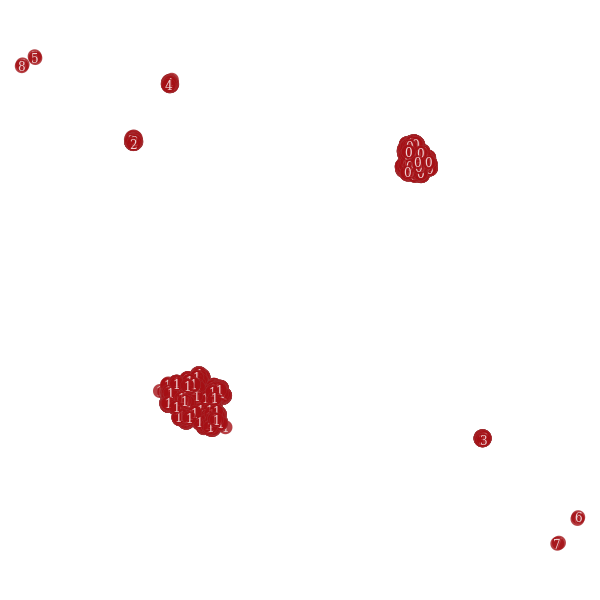

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f19c79227f0, at 0x7f19b72dc0f0>

In [8]:
graph_draw(g,edge_pen_width=prop_to_size(g.ep.ident), vertex_text=comp)

In [5]:
comp, hist = label_components(g)

In [6]:
hist

array([14455, 29279,   466,   350,   247,     2,     2,     2,     2],
      dtype=uint64)

In [9]:
def get_representative_domain(frag,comp):
        degrees=[]
        for vertex in g.vertices():
            v1 = g.vertex(vertex)
            degrees.append(v1.out_degree())
        degree = [(x, i) for i, x in enumerate(degrees) if comp.a[i] == frag]
        most_connected_vertices = [x[1] for x in degree if x[0] == max(degree)[0]]
        # if there are several vertices equally connected, select that one
        # whose length is the closest to the average.
        if len(most_connected_vertices) > 1:
            target = g.sizes[frag][0]
            verts_len = []
            for vertex in most_connected_vertices:
                start = int(round(np.mean(g.vp.start[vertex])))
                end = int(round(np.mean(g.vp.end[vertex])))
                length = int(end) - int(start)
                verts_len.append(length)
            vertice = most_connected_vertices[min(range(len(verts_len)), key=lambda i: abs(verts_len[i] - target))]
        else:
            vertice = most_connected_vertices[0]
        return vertice

In [12]:
[g.vp.name[index] for index,fragment in enumerate(comp.a) if fragment==2]

['4.2.1.1_10026',
 '4.2.1.1_10062',
 '4.2.1.1_10205',
 '4.2.1.1_10290',
 '4.2.1.1_10332',
 '4.2.1.1_10518',
 '4.2.1.1_10609',
 '4.2.1.1_10734',
 '4.2.1.1_10762',
 '4.2.1.1_10902',
 '4.2.1.1_10931',
 '4.2.1.1_11075',
 '4.2.1.1_11168',
 '4.2.1.1_11212',
 '4.2.1.1_11219',
 '4.2.1.1_11458',
 '4.2.1.1_11477',
 '4.2.1.1_11539',
 '4.2.1.1_11599',
 '4.2.1.1_11812',
 '4.2.1.1_11986',
 '4.2.1.1_12193',
 '4.2.1.1_12194',
 '4.2.1.1_12361',
 '4.2.1.1_12404',
 '4.2.1.1_12410',
 '4.2.1.1_12534',
 '4.2.1.1_12626',
 '4.2.1.1_12731',
 '4.2.1.1_12769',
 '4.2.1.1_12879',
 '4.2.1.1_1308',
 '4.2.1.1_13219',
 '4.2.1.1_13377',
 '4.2.1.1_13429',
 '4.2.1.1_13462',
 '4.2.1.1_13517',
 '4.2.1.1_13571',
 '4.2.1.1_14274',
 '4.2.1.1_1432',
 '4.2.1.1_14332',
 '4.2.1.1_14489',
 '4.2.1.1_14565',
 '4.2.1.1_14698',
 '4.2.1.1_14755',
 '4.2.1.1_14781',
 '4.2.1.1_1479',
 '4.2.1.1_15035',
 '4.2.1.1_1512',
 '4.2.1.1_15286',
 '4.2.1.1_15524',
 '4.2.1.1_15577',
 '4.2.1.1_15654',
 '4.2.1.1_15655',
 '4.2.1.1_15727',
 '4.2.1.1_1579